In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import yaml

from scipy.stats import ks_2samp
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from statsmodels.distributions.empirical_distribution import ECDF

In [3]:
filepaths = yaml.load(open("../config/filepaths.yaml"))
credentials = yaml.load(open("../config/credentials.yaml"))["perspective-api"]

/tmp/ipykernel_1657829/1089545284.py:1: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  filepaths = yaml.load(open("../config/filepaths.yaml"))
/tmp/ipykernel_1657829/1089545284.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  credentials = yaml.load(open("../config/credentials.yaml"))["perspective-api"]


In [8]:
data = pd.concat(
    [
        pd.read_csv(file) \
            .assign(
                id=file.split('/')[-1],
                race=file.split('/')[-1].split('-')[0],
                gender=file.split('/')[-1].split('-')[1],
                group='_'.join(file.split('/')[-1].split('-')[:2])
                
            )
        for file in glob.glob(filepaths['interview_scored']+'*')
    ]
)

data

,text,perspective_score,flair_score,textblob_score,vader_score,id,race,gender,group
0,They are taxpayer-owned entities.,0.028611,0.156813,0.444444,0.000,white-f-gretchen morgenson,white,f,white_f
1,The taxpayer has had to support them to the tu...,0.010759,0.195123,0.388889,0.000,white-f-gretchen morgenson,white,f,white_f
2,That's by no means the end of the line.,0.020131,0.983766,0.444444,0.216,white-f-gretchen morgenson,white,f,white_f
3,"There will be further losses, undoubtedly.",0.050242,0.999908,0.444444,0.351,white-f-gretchen morgenson,white,f,white_f
4,But what you're seeing now is the effects of t...,0.014091,0.924223,0.444444,0.091,white-f-gretchen morgenson,white,f,white_f
...,...,...,...,...,...,...,...,...,...
50,And the fact that in one-third of the counties...,0.016729,0.998135,0.372549,0.000,white-m-leonard lance,white,m,white_m
51,"In New Jersey, we originally had five insurers...",0.012773,0.866710,0.261364,0.000,white-m-leonard lance,white,m,white_m
52,We're now down to two.,0.027066,0.998618,0.503268,0.000,white-m-leonard lance,white,m,white_m
53,And that is why I hope that at some point - an...,0.029126,0.232839,0.411765,0.000,white-m-leonard lance,white,m,white_m


In [9]:
data['len'] = data.text.str.len()

KeyboardInterrupt: 

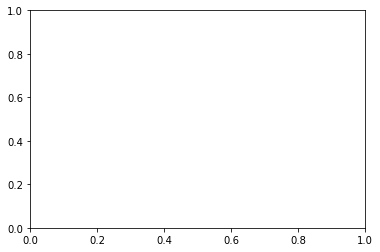

In [15]:
sns.histplot(data, y='len', bins=20)
plt.show()

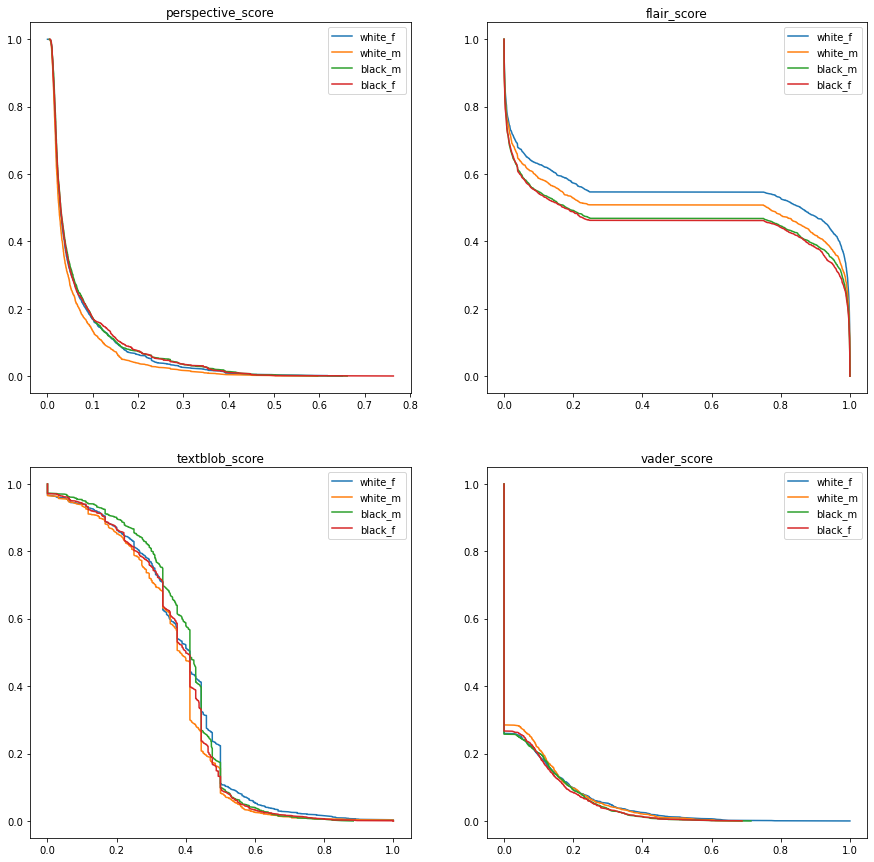

In [21]:
figure, axis = plt.subplots(2, 2, figsize=(15,15))
axis = axis.flatten()
scores = ['perspective_score','flair_score','textblob_score','vader_score']

for score_i in range(len(scores)):
    for group in data.group.unique():
        ecdf = ECDF(data[data.group==group][scores[score_i]])    
        axis[score_i].plot(ecdf.x, 1-ecdf.y, label=group)

    # axis[score_i].set(yscale='log')
    axis[score_i].set_title(scores[score_i])
    
    axis[score_i].legend()

plt.show()


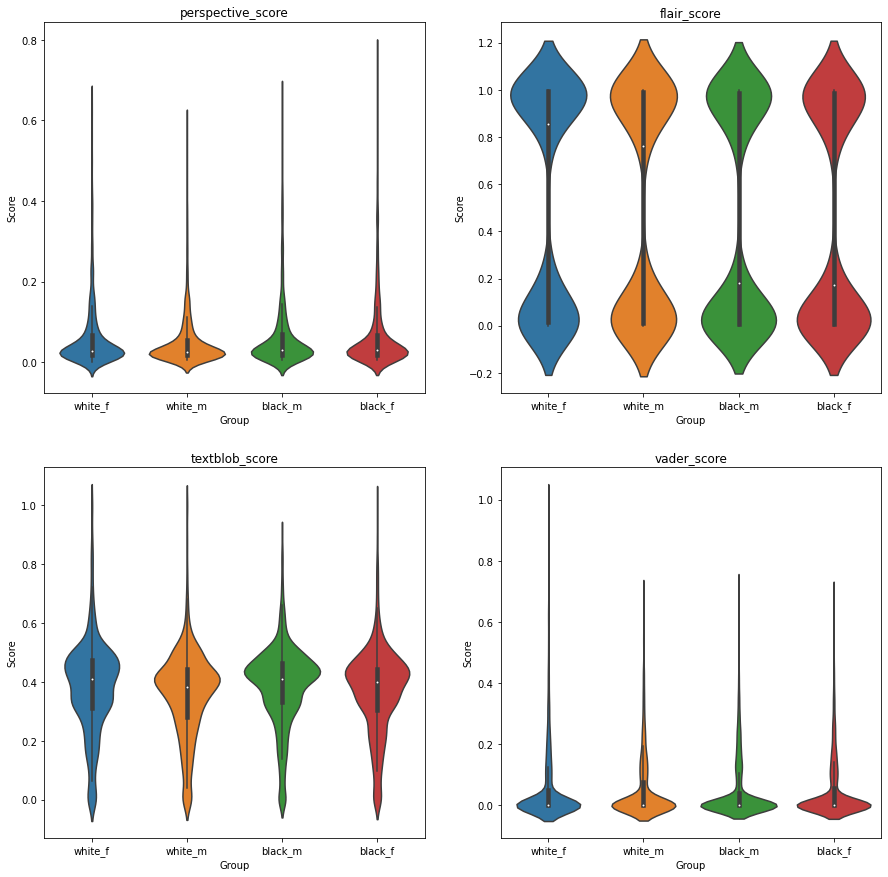

In [22]:
figure, axis = plt.subplots(2, 2, figsize=(15,15))
axis = axis.flatten()
scores = ['perspective_score','flair_score','textblob_score','vader_score']

for score_i in range(len(scores)):

    sns.violinplot(x="group", y=scores[score_i], showfliers=False, data=data, ax=axis[score_i])

    axis[score_i].set(xlabel="Group")
    axis[score_i].set(ylabel="Score")
    axis[score_i].set(title=scores[score_i])

plt.show()

In [23]:
statistic, p_value = ks_2samp(
    data[data.corpus == 'coraal'].perspective_score,
    data[data.corpus == 'buckeye'].perspective_score
)
statistic, p_value

AttributeError: 'DataFrame' object has no attribute 'corpus'

In [26]:
data[data.group == first_group][score_name]

0     0.155097
1     0.164825
2     0.184506
3     0.023975
4     0.031873
        ...   
50    0.016729
51    0.012773
52    0.027066
53    0.029126
54    0.010135
Name: perspective_score, Length: 1499, dtype: float64

In [27]:
score_name = 'perspective_score'

ks_all = []
groups = data.group.unique()
for first_group in groups:
    ks_one_vs_all = []
    for second_group in groups:
        statistic, p_value = ks_2samp(
            data[data.group == first_group][score_name],
            data[data.group == second_group][score_name]
        )
        
        ks_one_vs_all.append(
            f"{np.abs(np.round(statistic*100, 3))} ({np.round(p_value*100, 3)})"
        )
    ks_all.append(ks_one_vs_all)

    # pd.DataFrame(ks_all, columns=groups, index=groups)

In [29]:
pd.DataFrame(ks_all, columns=groups, index=groups)

,white_f,white_m,black_m,black_f
white_f,0.0 (100.0),5.174 (2.596),4.166 (7.701),3.198 (33.499)
white_m,5.174 (2.596),0.0 (100.0),7.399 (0.016),6.593 (0.186)
black_m,4.166 (7.701),7.399 (0.016),0.0 (100.0),2.474 (61.539)
black_f,3.198 (33.499),6.593 (0.186),2.474 (61.539),0.0 (100.0)
